## 1 SIFT 
### 1.1 Prétraitement des données 

    - Changement de taille des images 
    - Filtre de l'image en gris
    - Extraction des descriptors 
    - Création des bag of images 
    
### 1.2 Classification supervisée des bag of images 
    - test avec de plusieurs modèles avec grid search cv
    - matrice de confusion sur les prédictions du modèle de régression logistique
 
## 2 Model pré-entrainé VGG16
### 2.1 Prétraitement des données     
    - Extraction des features 
    - PCA
    - T-SNE
    - Matrice de confusion

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import time
import datetime

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
df = pd.read_csv('Source/flipkart_com-ecommerce_sample_1050.csv',sep=',')

In [10]:
path_img = 'Source/Images'

In [11]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [12]:
# lire des caractère sur une image
import nltk
nltk.download('punkt')
tokenizer = nltk.RegexpTokenizer(r'\w+')
token = np.array(df.product_category_tree)

token = [tokenizer.tokenize(i.lower()) for i in token]

bigram = [list(nltk.bigrams(bigram)) for bigram in token]

token_bigram = pd.Series(bigram)

cat_name = np.array([token_bigram[i][0] for i in range(len(token_bigram))])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 

In [14]:
df['category_name'] = df_token

In [15]:
from sklearn import preprocessing


# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df.category_name)
df["label"] = encodage.transform(df.category_name)
# data.head(5)
df.category_name.value_counts()

home         300
baby         150
watches      150
kitchen      150
beauty       150
computers    150
Name: category_name, dtype: int64

In [16]:
img = [img for img in df.image]
img_path = []

for i in range(len(img)):
    img_path.append(path_img+"/"+img[i])
    df['path_img'] = path_img+"/"+img[i]

In [17]:
img_path[1]

'Source/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg'

### 1 SIFT 
### 1.1Prétraitement des données

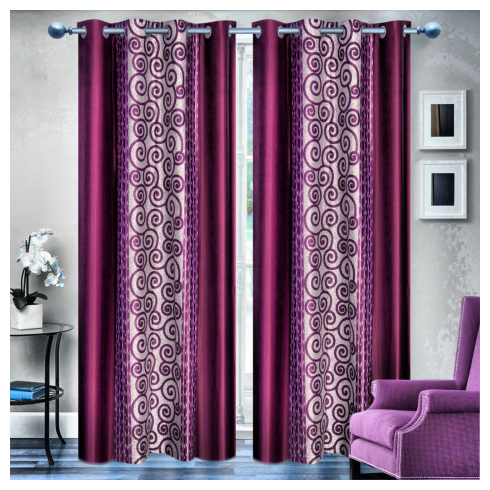

Text(0.5, 1.0, 'Adaptive equalization')

In [18]:
# egalizateur de contraste

from skimage import data, img_as_float
from skimage import exposure
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img = axes
    #ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    
    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()
img = cv2.imread(img_path[0])
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
# Display results
fig = plt.figure(figsize=(8, 5))
axes = plt.subplot()
plot_img_and_hist(img_adapteq, axes)
axes.set_title('Adaptive equalization')

temps :             0.99 secondes


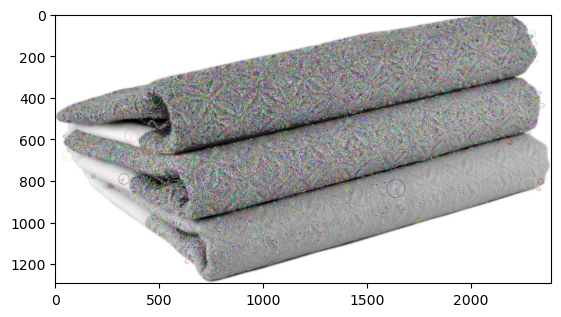

In [19]:
# Important NOTE: Use opencv <= 3.4.2.16 as
# SIFT is no longer available in
# opencv > 3.4.2.16


time1 = time.time()

# Loading the image
img_ = cv2.imread(img_path[1],cv2.IMREAD_GRAYSCALE)


# Converting image to grayscale
gray= cv2.cvtColor(img_,cv2.COLOR_GRAY2BGR)


# Applying SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
keyp , descript = sift.detectAndCompute(gray,None)


# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      keyp ,
                      0,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

duration1=time.time()-time1
print("temps : ", "%15.2f" % duration1, "secondes")

plt.imshow(img)

### Extraction des descriptors 

In [20]:
time1 = time.time()

image_descripteur = []
image_descripteur_org = []
image_features = []
for idx,image_file in enumerate(img_path) :
    if idx%100 == 0: print('cpt = ',idx)
    # Loading the image
    img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, (500, 500))
    # egaliseur de couleur

    # Converting image to grayscale
    gray= cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Utilisez img au lieu de img_

    # Applying SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    #img_adapteq = exposure.equalize_adapthist(img_, clip_limit=0.03)

    # Convertir l'image en uint8 (CV_8U)
    #img_adapteq_uint8 = (img_adapteq).astype('uint8')
    kp , descripteurs = sift.detectAndCompute(gray,None)

    # Marking the keypoint on the image using circles
    img_ =cv2.drawKeypoints(gray  ,
                          kp ,
                          0,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    try : 
        
        descripteurs_norm = np.linalg.norm(descripteurs, axis=1, keepdims=True)
        descripteurs_normalises = descripteurs / descripteurs_norm
    except : 
        descripteurs_normalises = 0
    
    # Seuillage des valeurs des vecteurs de descripteurs
    seuil = 0.2
    descripteurs_seuilles = np.minimum(descripteurs_normalises, seuil)
    image_descripteur_org.append(descripteurs)
    image_descripteur.append(descripteurs_seuilles)
    image_features.append(img_) 
    #image_kp.append([key.pt for key in key_points])

duration1=time.time()-time1
print("temps : ", "%15.2f" % duration1, "secondes")

cpt =  0
cpt =  100
cpt =  200
cpt =  300
cpt =  400
cpt =  500
cpt =  600
cpt =  700
cpt =  800
cpt =  900
cpt =  1000
temps :            78.09 secondes


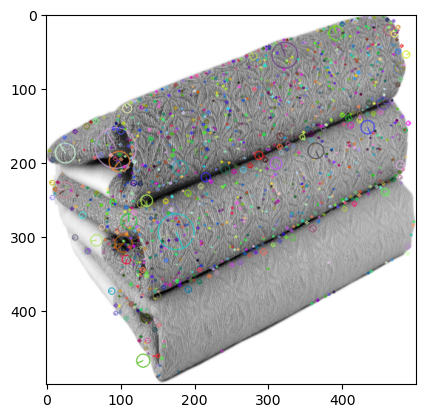

In [21]:
plt.imshow(image_features[1])

In [22]:
# check que les lignes ne sont pas vide avant de concaténer 
for i,des in enumerate(image_descripteur_org):
    try:
        #print('i:',i,'___',des.shape[0])
        if len(des) != 0:
            continue
    except:
        print('error ligne :',i)
        image_descripteur_org[i] = np.zeros((1,128))
        

error ligne : 343


In [23]:
len(image_descripteur)

1050

In [24]:
descripteurs = np.concatenate(image_descripteur_org,axis=0)

descripteurs.shape


(964010, 128)

In [25]:
#image_descripteur_org = np.concatenate(image_descripteur_org,axis=0)
#image_descripteur_org.shape

In [26]:
descripteurs[11100]

array([ 28.,   1.,   0.,   0.,   0.,   0.,   0.,   2., 151.,   4.,   1.,
         3.,   1.,   0.,   0.,  21., 100.,   8.,   4., 140., 143.,   0.,
         0.,   3.,   0.,   0.,   0.,  97., 112.,   0.,   0.,   0.,  41.,
         1.,   0.,   0.,   0.,   2.,   4.,  12., 151.,  11.,   2.,  20.,
        13.,   0.,   0.,  33.,  71.,   8.,   3., 151., 151.,   0.,   0.,
         2.,   0.,   0.,   1.,  56.,  65.,   0.,   0.,   0.,  19.,   2.,
         2.,   0.,   0.,  11.,  33.,  36., 151.,  84.,  15.,  24.,  19.,
         0.,   1.,  31.,  16.,  26.,  15., 103., 151.,  21.,   0.,   0.,
         0.,   0.,   0.,  10.,  28.,  13.,   5.,   0.,  20.,  19.,  16.,
         0.,   1.,   3.,   7.,   8.,  10.,  49.,  17.,   6.,   5.,   2.,
         2.,   4.,   1.,  22.,  27.,  22.,  53.,  22.,   1.,   1.,   0.,
         1.,   7.,   7.,  13.,  26.,  15.,   0.])

### Création des bag of images 

In [27]:
from sklearn import cluster, metrics
import math
import time
time1 = time.time()

#k = int(round(math.sqrt(len(descripteurs)),0))
k = 80
print('nombre de clusters : ',k)
cls = cluster.MiniBatchKMeans(n_clusters=k,random_state=0, init_size=3*k)
cls.fit(descripteurs)


duration1=time.time()-time1
print("temps du Kmeans : ", "%15.2f" % duration1, "secondes")

ImportError: cannot import name '_fit_context' from 'sklearn.base' (C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\base.py)

In [ ]:
cls.cluster_centers_.shape

In [ ]:
cls.labels_.min(),cls.labels_.max()

In [ ]:
cls.n_clusters

In [ ]:
def buil_histogram(kmeans,descripteur):
    try:
        des_pred = kmeans.predict(descripteur)
        nb_des = len(descripteur)

        val, _ = np.histogram(des_pred,bins = np.arange(cls.n_clusters+1))
        # normalise les bags of features
        return val/nb_des

    except:
        print('erreur histogramme')
        return np.zeros(len(kmeans.cluster_centers_))

histogram_descripteurs = []

In [ ]:
df.head()

In [ ]:
des = np.array(image_descripteur_org[1],dtype = np.float64)
des_pred = cls.predict(des)
val, _ = np.histogram(des_pred,bins = np.arange(cls.n_clusters+1))
des2 = np.array(image_descripteur_org[2],dtype = np.float64)
des_pred2 = cls.predict(des2)
val2, _ = np.histogram(des_pred2,bins = np.arange(cls.n_clusters+1))
des3 = np.array(image_descripteur_org[23],dtype = np.float64)
des_pred3 = cls.predict(des3)
val3, _ = np.histogram(des_pred3,bins = np.arange(cls.n_clusters+1)
                      )
fig, ax = plt.subplots(3,2,figsize= (10,7))
fig.subplots_adjust(hspace=1.3)

ax[0][0].imshow(image_features[1])
ax[0][0].set_xlabel('class baby')
ax[0][0].set_title('Image 1')
ax[0][1].hist(val,bins = np.arange(cls.n_clusters+1))
ax[0][1].set_xlabel('Cluster')
ax[0][1].set_ylabel('nb features')
ax[0][1].set_title('Image 1')
ax[1][0].imshow(image_features[2])
ax[1][0].set_xlabel('class baby')
ax[1][0].set_title('Image 2')
ax[1][1].hist(val2,bins = np.arange(cls.n_clusters+1))
ax[1][1].set_xlabel('Cluster')
ax[1][1].set_ylabel('nb features')
ax[1][1].set_title('Image 2')
ax[2][0].imshow(image_features[3])
ax[2][0].set_xlabel('class home')
ax[2][0].set_title('Image 3')
ax[2][1].hist(val3,bins = np.arange(cls.n_clusters+1))
ax[2][1].set_xlabel('Cluster')
ax[2][1].set_ylabel('nb features')
ax[2][1].set_title('Image 3')


In [ ]:
len(descripteurs),cls.n_clusters,len(cls.cluster_centers_)

In [ ]:
import time

t0 = time.time()

for i in range(len(image_descripteur_org)):
    des = np.array(image_descripteur_org[i],dtype = np.float64)
    histogram_descripteurs.append(buil_histogram(cls,des))
    if i%200 ==0:print(i)
    
time = time.time() - t0

print(f'temps d execution : {time}')

In [ ]:
histogram_descripteurs[0]

In [ ]:
#df_feat = pd.DataFrame(histogram_descripteurs).fillna(0)

In [ ]:
from sklearn import manifold, decomposition

print(histogram_descripteurs[0].shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(histogram_descripteurs)
print(feat_pca.shape)

In [ ]:
import time
temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(histogram_descripteurs)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["cluster"] = df["label"]
df_tsne['cluster'].unique()

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")



In [ ]:

plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

## 1.2 Classification supervisée des bag of images 

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
model = SVC()

Scaller = StandardScaler()

X = histogram_descripteurs
y = df.label

X = Scaller.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array([list(x) for x in X_train])


model.fit(X_train,y_train)
y_pred = model.predict(X_test)

score = model.score(X_test,y_test)     
print(f" score = {round(score,2)} ")



In [ ]:
len(image_descripteur_org[0])

In [ ]:
# test de prédiction 
test = np.array(image_descripteur_org[10],dtype = np.float64)
predictions = cls.predict(test)
pred,_ = np.histogram(predictions, bins=np.arange(cls.n_clusters +1)/len(image_descripteur_org[1030]))

result = model.predict(pred.reshape(1,-1))
print(f'categorie de image : {df.label[104]}, resultat prediction : {result}')

In [ ]:
t0 = time.time()

pipe = Pipeline([
                ("estimator",LogisticRegression())
                ])
pipe


X = histogram_descripteurs
y = df.label


param_grid = {
              'estimator':[RandomForestClassifier(),
                           AdaBoostClassifier(),
                           GradientBoostingClassifier(),
                           ExtraTreesClassifier(),
                           DecisionTreeClassifier(),
                           SVC(),
                           BaggingClassifier(),
                           KNeighborsClassifier(13),
                           LogisticRegression()
                          ]}


grid = GridSearchCV(pipe,param_grid=param_grid, cv=5,return_train_score=True ,n_jobs=-1, verbose=1)

grid.fit(X,y)

grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

duration1=time.time() - t0
print("temps : ", "%15.2f" % duration1, "secondes")

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

## 2 Model pré entrainé VGG16

In [ ]:
from matplotlib.image import imread

image = imread(img_path[1])
plt.imshow(image)

### 2.1 Prétraitement des données     

    - Test avec de plusieurs modèles avec grid search cv
    - matrice de confusion sur les prédictions du modèle de régression logistique

In [ ]:
base_model = VGG16()

model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

###     Extraction des features 

In [ ]:
import time

images_features = []
i=0 
t0 = time.time()
images__ = []
for image_file in img_path :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image__ = image
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model
    
duration1=time.time() - t0
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")
images_features = np.asarray(images_features)
images_features.shape

### PCA

In [ ]:
image = load_img(img_path[2], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
print(image.shape)
image___ = preprocess_input(image)
print(image___[0].shape)
plt.imshow(image___[0])

In [ ]:
images_features[0].shape

In [ ]:
image = load_img(img_path[2], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
pred_ = base_model.predict(image, verbose=0)
decode_predictions(
    pred_,top=10
)

In [ ]:
base_model.inputs
base_model.layers[-2].output

In [ ]:
img_path[0]

In [ ]:
#image = tf.image.decode_png(img_path[0])

In [ ]:
test = images_features[0]

In [ ]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

In [ ]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label"]
df_tsne['class'].unique()

In [ ]:


plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()


In [ ]:
len(X_tsne[1])

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=6, n_init=100)
cls.fit(X_tsne)

In [ ]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Matrice de confusion

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(metrics.classification_report(labels, cls_labels_transform))

In [ ]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
X_tsne[0].reshape(1,-1)

In [ ]:
cls.labels_

In [ ]:
# Les 4 premières sessions de fidle
# la data aumentation (focus) sans moindre 